In [86]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random as rnd
import collections
import copy
import pprint
from operator import itemgetter

# Notebook plot inline mode
%matplotlib inline

#Activate autocompletion
%config IPCompleter.greedy=True

#plot constants
fontsize=15

### EPIDEMIC PROCESS ON A SOCIAL NETWORK

### 1.1 - Consider either a synthetic Barabasi-Albert graph or a real social network (e.g., from the SNAP http://snap.stanford.edu/ or Konect http://konect.uni-koblenz.de/ repositories). If the chosen graph has multiple disconnected components, select the largest connected component. Make sure the graph has at least a few thousand nodes. Compute and plot the degree distribution.

n: 3953 m: 8 seed: 505


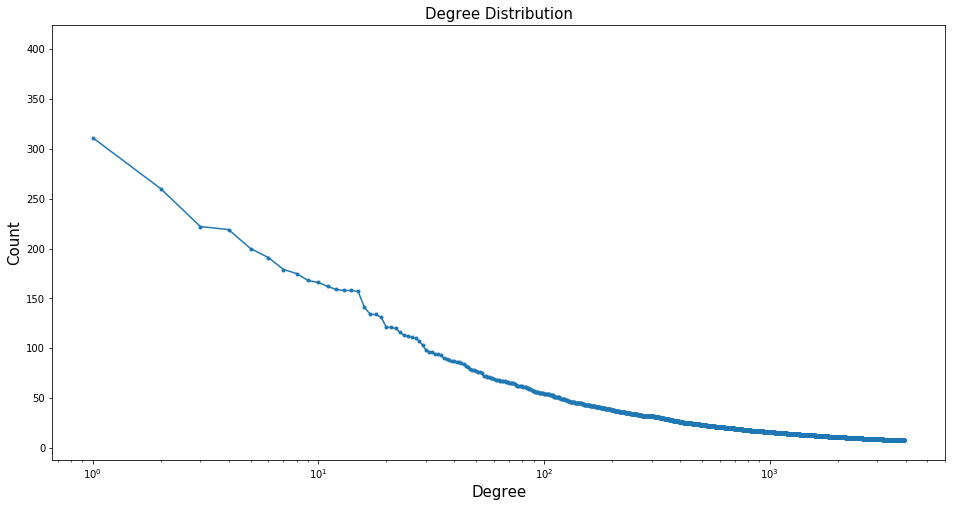

In [92]:
#seed for RNG
seed = np.random.randint(1e3)
# Make sure that the generated Barabasi-Albert graph is connected, if not(very unlucky), generate a new one.
def random_barabasi_albert_graph():
    while True:
        np.random.seed(seed)
        # Choose randomly the number of nodes
        n = np.random.randint(1e3,4e3)
        # Choose randomly the m parameter
        m = np.random.randint(2,9)
        G = nx.barabasi_albert_graph(n, m, seed=seed)
        print("n:",n,"m:",m,"seed:",seed)
        if nx.is_connected(G):
            return G

G = random_barabasi_albert_graph()

# Obtain degree sequence from the generated graph
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

#Parametrize and plot the figure
plt.rcParams['figure.figsize'] = (16, 8)
fig, ax = plt.subplots()
plt.semilogx(degree_sequence, '.-')
_ = plt.title("Degree Distribution", fontsize=fontsize)
_ = plt.ylabel("Count", fontsize=fontsize)
_ = plt.xlabel("Degree", fontsize=fontsize)


### 1.2 - Set up a simulation of an SIR epidemic process on the graph. Start the epidemic from a randomly chosen node. Choose values of model parameters $\beta$ and $\mu$ that allow the epidemic to take off with high probability, reaching most of the nodes.

As we have seen during the classroom practicing, define a class that allows to run a SIR model simulation taking a graph $G$, parameters $\beta$ and $\mu$. Moreover tuing the parameter *num_steps* of *run* is possible to define the granularity of the returned map.

In [93]:
class SIRSimulator:
    def __init__(self, graph, beta=0.25, mu=0.05):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        
    def run(self, seed=[], num_steps=1):
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            largest_cc = max(nx.connected_components(self.g), key=len)
            seed = rnd.sample(largest_cc,1)
            
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set)
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(self.g.neighbors(i)):
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1
  

A good choice of $\beta$ and $\mu$ need to consider the epidemic threshold $\frac{\beta}{\mu}>1$. But doesn't seem to make much sense execute an optimization of the paramenters because to maximize the epidemic spread $\beta$ will be maximized and $\mu$ will be minimized. Let's try.

In [94]:
def infection_rate(G, BETA, MU):
    sir = SIRSimulator(G, BETA, MU)
    nodes_number = len(G.nodes())
    max_infection_rate = 0
    for status in sir.run(num_steps=1):     
        if len(status['I'])/nodes_number > max_infection_rate:
            max_infection_rate = len(status['I'])/nodes_number
    return max_infection_rate
                                    
beta_array = [0.25, 0.5, 0.75, 1]
mu_array   = [0.005 ,0.01, 0.05, 0.1]
max_infection_rate = (0, 0, 0)
    
for beta in beta_array:
    for mu in mu_array:
        current_infection_rate = infection_rate(G, beta, mu)
        if max_infection_rate[0] < current_infection_rate:
            max_infection_rate = (current_infection_rate, beta, mu)

print(max_infection_rate)

(0.9967113584619276, 0.75, 0.005)


Thist confirms what we thought about $\beta$ and $\mu$. Hence, for our simulation we choose reasonable values for $\beta$ and $\mu$, not much aggressive but enough to satisfy the request. Now we're going to plot the epidemic trend w.r.t. $S$, $I$, and $R$ nodes.

In [95]:
BETA = 0.5
MU = 0.05

Start and plot the simulation

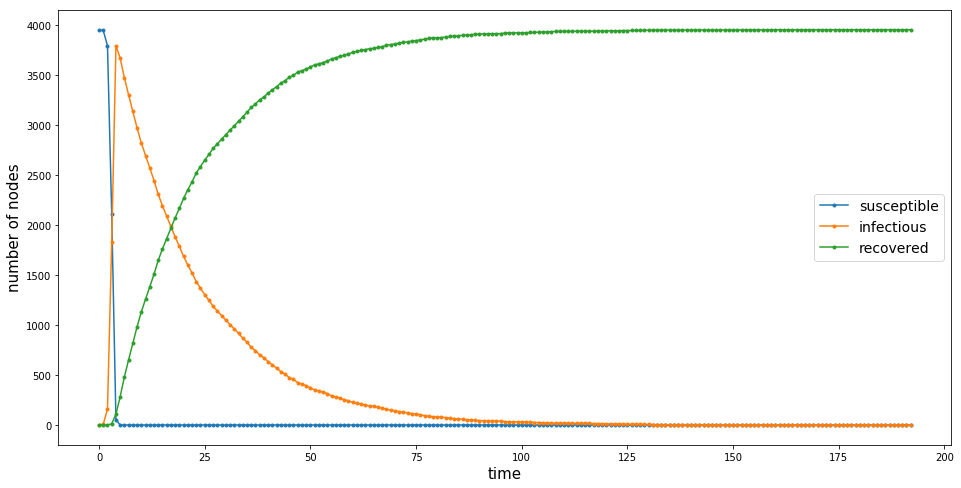

In [96]:
SIR = SIRSimulator(G, BETA, MU)

plt.figure(figsize=(16,8))
plt.plot([ 
    (len(status['S']), 
     len(status['I']),
     len(status['R'])) for status in SIR.run()], 
    '.-')
plt.xlabel('time', fontsize=fontsize)
plt.ylabel('number of nodes', fontsize=fontsize)
_=plt.legend(['susceptible', 'infectious', 'recovered'], fontsize=14, loc=7)

### 1.3 -  Plot epidemic curves for multiple stochastic realizations of the epidemic. Compute the probability distribution of the overall attack rate (number of recovered nodes at the end of the simulation / total number of nodes) and the probability distribution of peak times for the epidemic. Display these distributions using boxplots.

In the next script we're going to plot and compare different instances of the simulation, despite we're dealing with a random procedure, once transiction rates $\beta$, $\mu$ and the graph $G$ are fixed we don't expect a really high variance phenomenon.

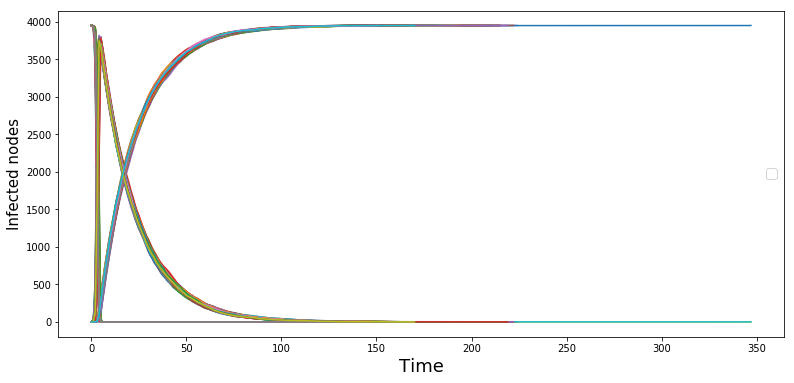

In [97]:
plt.figure(figsize=(13,6))    
plt.xlabel('Time', fontsize=18)
_=plt.ylabel('Infected nodes', fontsize=fontsize)
_=plt.legend(['susceptible', 'infectious', 'recovered'], fontsize=14, loc=7)

for _ in range(100):
    simulation = SIR.run(num_steps=1)
    plt.plot(
        [ 
        (len(status['S']), 
         len(status['I']),
         len(status['R'])) for status in simulation
        ], 
        '-')

In order to compute the probability distribution of the overall attack rate and peak times we could use a simple function that for a given isntance of the simulation extract $\frac{Recovered Nodes}{Number Of Nodes}$ and save the time at each the maximum number of infected node has found.

In [98]:
def attack_rate_peak_times(simulation):
    max_inf = 0
    max_t = 0
    for status in simulation:
        recovered = len(status['R'])
        if max_inf < len(status['I']):
            max_t = status['t']
    return recovered/len(G.nodes()), max_t

attack_rate_peak_arr = []
for _ in range(20):
    attack_rate_peak_arr.append(attack_rate_peak_times(SIR.run(num_steps=1)))

Follows boxplots for Attack Rate distribution and Peak Times distribution computed just above

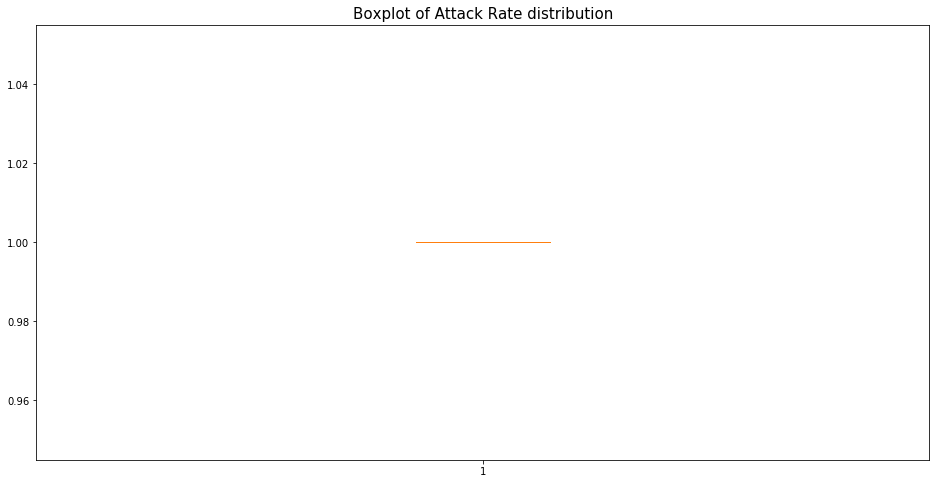

In [99]:
_=plt.title("Boxplot of Attack Rate distribution", fontsize=fontsize)
_=plt.boxplot([x[0] for x in attack_rate_peak_arr])

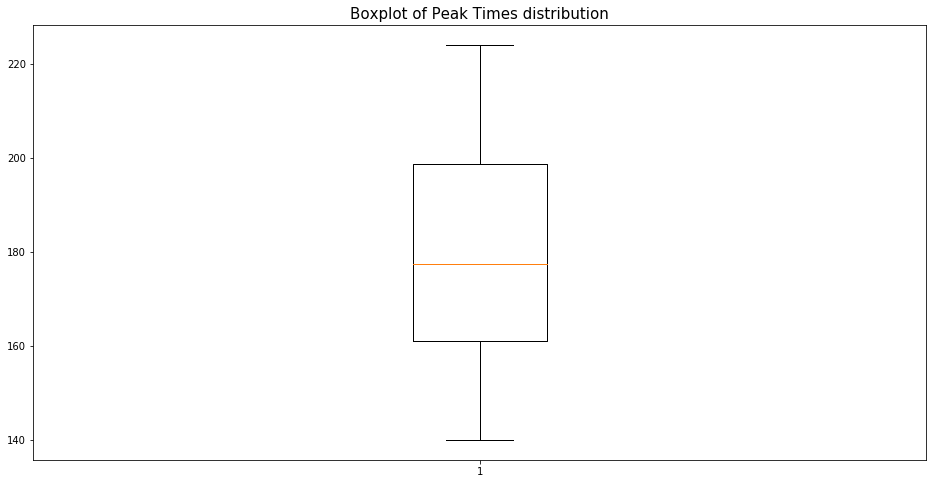

In [100]:
_=plt.title("Boxplot of Peak Times distribution", fontsize=fontsize)
_=plt.boxplot([x[1] for x in attack_rate_peak_arr])

### PART 2: VACCINATION AND HERD IMMUNITY

### 2.1 - Modify the simulation above so that it supports a given initial fraction r of randomly chosen "immunized" nodes, i.e., nodes that cannot be infected. Can you provide an upper bound for the overall attack rate without having to simulate the epidemic?

In order to support a given initial fraction $r$ of randomly immunized nodes we can insert r as a initializing parameter of the simulation class, and with some slight modifications we'll obtain an r-immunized graph. In particular, remove a fraction $r$ of the nodes from the graph make us sure about their immunization since a not present node cannote be infected. Another possible strategy could be to insert the randomly selected nodes into the set of the recovered nodes $R$ but it needs a few adjustments in the counting process, for this reason I opt for the first option.

Regarding the upper bound for the overall attack, of course allow a certain number of immunized nodes influence the maximum number of nodes that can be infected during the epidemic. Then, in a netwok containing $N$ nodes and a fraction $r$ of immunized nodes an upper bound to the overall attack rate is:
$$\frac{N - Nr}{N} = 1-r$$
Now in order to setup the simulation all we need to do is to remove randomly a fraction $r$ of the nodes, for example in this way:

In [101]:
def remove_nodes_randomly(G, r):
    # Copy the original graph
    G_copy = copy.deepcopy(G)                   
    # Number of immunized nodes
    n_immunized = int(r*len(G_copy.nodes()))
    # Let's select n_immunized nodes at random from the graph
    to_remove = np.random.choice(G_copy.nodes(), size = n_immunized, replace=False)
    # Finally removes them for our graph
    G_copy.remove_nodes_from(to_remove)
    return G_copy

### 2.2 - For a range of values of the initial fraction of immunized nodes (e.g., r = 0.01, 0.1, 0.5, 0.8, 0.9, ...) simulate the SIR epidemic above (multiple realizations for each value of r) and plot the overall attack rate as a function of the fraction r of immunized nodes.

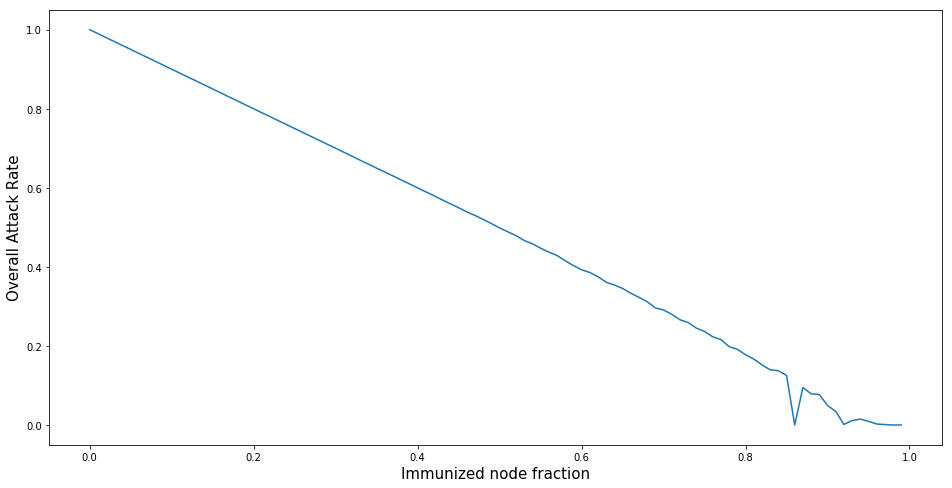

In [102]:
# Select equidistant values from 0 to 1
r_arr = np.arange(0, 1, 0.01)

# Function to compute only the attack rate
def attack_rate(simulation, num_nodes):
    max_inf = 0
    for status in simulation:
        recovered = len(status['R'])
    return recovered/num_nodes

def attack_rate_over_r(r_arr, G):
    attack_rate_arr = []
    for r in r_arr:
        G_immun = remove_nodes_randomly(G, r)
        # Run the simulation on the modified graph
        SIR_immun = SIRSimulator(G_immun, BETA, MU)
        # Append the simulation value for the curent simulation
        attack_rate_arr.append(attack_rate(SIR_immun.run(num_steps=1), len(G.nodes())))
    return attack_rate_arr

attack_rate_arr_ba = attack_rate_over_r(r_arr, G)

_=plt.xlabel('Immunized node fraction', fontsize=fontsize)
_=plt.ylabel('Overall Attack Rate', fontsize=fontsize)
_=plt.plot(r_arr, attack_rate_arr_ba)

The result we obtained in the previous simulation is kind of predictable, the attack rate is inversely proportional to the fraction of immunized nodes $r$. Notice that sometimes in some point there are drastic drops of the attack rate and they are more likely to appear when $r$ is approaching 1. That's because while we're deleting most of the nodes exists an high probability to remove a node with a huge degree (nodes inserted at the beginning of barabasi albert generation process), such a  behavior in some way could disconnect the graph. Despite we take the starting node randomly inside the largest connected components, if the simulation is really unlucky there's no way for the epidemic to take off.

### 2.3 - Generate a random Erdős–Rényi graph with the same size and density as the original social network. Repeat the experiment 2.2 above. Compare the results you obtain in this case and in the previous case, and explain the differences you observe.

Taking as reference [Erdős–Rényi model wikipedia page](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) exists two closely related version of this model:
* The $G(n,m)$ model in which a graph is chosen uniformly at random from the collection of all graphs with $n$ nodes and $m$ edges.
* The $G(n, p)$ model in which a graph is constructed by connecting nodes randomly. Each edge is included in the graph with probability p independent from every other edge.

Our goal is to build a graph with the same size and __density__ of the one previously generated, since a graph density is [defined](https://en.wikipedia.org/wiki/Dense_graph) as:
$$ d = \frac{2|E|}{|V|(|V|-1)} $$
That's clearly a function of $V$ and $E$ we must ensure that the generated Erdős–Rényi will have the same number of edges and nodes of the starting graph. For this reason I'm going to use the first model because it gives us more "direct" control on the graph's structure.

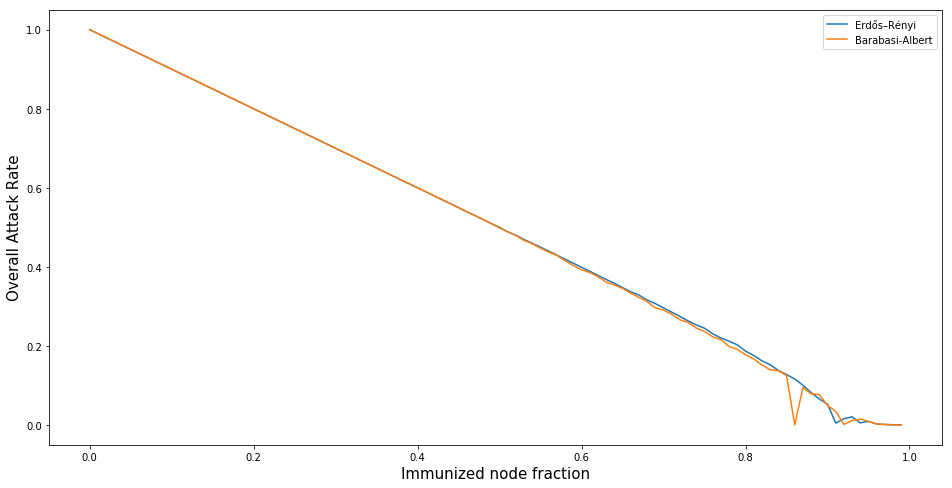

In [103]:
# instantiate a Erdős–Rényi graph using gnm_random_graph
er_graph = nx.gnm_random_graph(len(G.nodes()), len(G.edges()), seed=seed, directed=False)

# compute the attack rate in order to compare with the barabasi albert model
attack_rate_arr_er = attack_rate_over_r(r_arr, er_graph)

_=plt.xlabel('Immunized node fraction', fontsize=fontsize)
_=plt.ylabel('Overall Attack Rate', fontsize=fontsize)
_=plt.plot(r_arr, attack_rate_arr_er, label = "Erdős–Rényi")
_=plt.plot(r_arr, attack_rate_arr_ba, label = "Barabasi-Albert")
_=plt.legend()

Runnning the same simulation on Erdős–Rényi graph, built as described above, brings us to pretty much the same results, attack rate is decreasing more or less linearly except for some points where it drop drasticly. Running the two snippets many times you'll notice that in the Barabasi-Albert model the drops are more likely to appear when $r$ is very near to 1, while on Erdős–Rényi graph the drops' starting point is pretty much shifted on the left.
That's because in the Erdős–Rényi graph generation process nodes inserted earlier has a huge probability to earn an high degree, while in the Erdős–Rényi the graph is chosen uniformly at random from the collection of all graphs with $n$  nodes and  $m$  edges.

### PART 3: TARGETED VACCINATION STRATEGIES

### 3.1 - Imagine that you have a "budget" of M vaccination doses, with M < N, where N is the size of your network. That is, you can immunize a fraction r = M/N of nodes. You have studied above the effect of randomly immunizing the network nodes. Can you improve the performance of immunization, in terms of reduced overall attack rate, by means of "targeted" immunization? That is, by choosing the nodes to be immunized according to some specific strategy rather than choosing them at random. Provide an example of such a strategy, and test it in simulation, comparing the results you obtain with those of Part 2.2.


We are now facing the problem of choosing which are best nodes to immunize in order to reduce the epidemic spread as much as possible. 
In other words we're interesed in removing from the graph all the nodes that, if infected, support the spreading of the epidemic more than the others.
My strategy is to remove from the graph the $\frac{M}{N}$ nodes with the highest degree. In this way we'are maximising number of edges removed, since the propagation takes place along the edges is natural to think that the epidemic spreading will be heavily reduced.

Let's modify the remove node function in order to remove the $\frac{M}{N}$ nodes with higher degrees, instead of removing it randomly.

In [104]:
def remove_higher_degree_nodes(G, M):
    # Copy the original graph
    G_copy = copy.deepcopy(G)                   
    # Select first M nodes with higher degree
    tuples_to_immunize = sorted(G.degree(G.nodes()), key=itemgetter(1), reverse=True)[:M]
    nodes_to_immunize = [int(t[0]) for t in tuples_to_immunize]
    # Remove nodes from the graph
    G_copy.remove_nodes_from(nodes_to_immunize)
    return G_copy

Let's now setup the simulation to record the attack rate on different $r$ and then plot it.

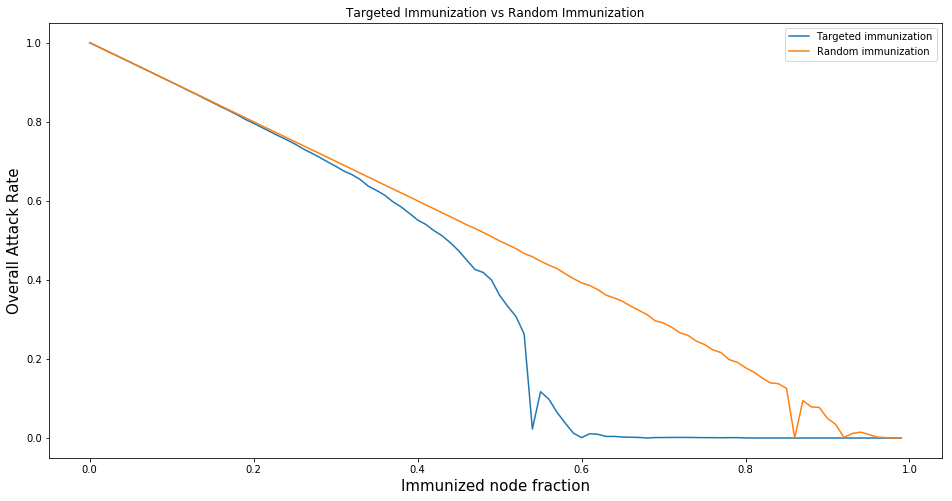

In [105]:
def attack_rate_over_r_targeted(r_arr, G):
    attack_rate_arr = []
    for r in r_arr:
        #Compute M
        M = int(r*len(G.nodes()))
        # Remove from the Graph M/N nodes with highest degrees
        G_immun = remove_higher_degree_nodes(G, M)
        # Run the simulation on the modified graph
        SIR_immun = SIRSimulator(G_immun, BETA, MU)
        # Append the simulation value for the curent simulation
        attack_rate_arr.append(attack_rate(SIR_immun.run(num_steps=1), len(G.nodes())))
    return attack_rate_arr

# Setup the simulation again for Random and Targeted Immunization
attack_rate_arr_targeted = attack_rate_over_r_targeted(r_arr, G)

_=plt.title("Targeted Immunization vs Random Immunization")
_=plt.xlabel('Immunized node fraction', fontsize=fontsize)
_=plt.ylabel('Overall Attack Rate', fontsize=fontsize)
_=plt.plot(r_arr, attack_rate_arr_targeted, label = "Targeted immunization")
_=plt.plot(r_arr, attack_rate_arr_ba, label = "Random immunization")
_=plt.legend()

As you can see from the graph just above, the strategy to immunize nodes with high degrees has stopped the epidemic with much less doses than in the Random Immunization process. So we can say that this strategy is definetively more efficient than the previous one. Very good!

### 3.2 - Now imagine that you still have a limited budget of M vaccination doses, but you cannot use information about the graph to decide how to use it. You can simulate a certain number of epidemics, without immunization, and use "historical" information on which nodes are infected (and when, and how often) to define your targeted immunization strategy. Design such a strategy and show its performance in simulation, comparing it to the random immunization of Part 2.2 and the targeted strategy you devised in Part 3.1 above.

In this setup we cannot access the information about the graph's topology to plan a vaccination strategy, in order to use the concept already used in point 3.1 we can exploit the time at each every nodes will be infected. Nodes with earlier infection time should be the nodes with higher degrees, that's because due to a massive presence of links they are very likely to be infected earlier in the process.

Let's define a function that determines, on the basis of serveral runs of the simulation, the average times at each node is visited.

In [40]:
def get_average_earlier_infected_nodes(iterations, G):
    # setup the simulation
    simulation = SIRSimulator(G, BETA, MU)
    #instatiate a dictionary with keys equals to set of nodes
    dict_node_time = dict.fromkeys(G.nodes())
    for _ in range(iterations):
        # for eache step of the simulation record the visit time into the dictionary
        for status in simulation.run(num_steps=1):
            current_nodes_StoI = status['S->I']
            for node in current_nodes_StoI:
                if dict_node_time[node] is None:
                    dict_node_time[node] = [status['t']]
                else:
                    dict_node_time[node].append(status['t'])
    # compute the mean for each node reorder in ascending way
    for key, value in dict_node_time.items():
        dict_node_time[key] = np.mean(value)
    sorted_dict_node_time = sorted(dict_node_time.items(), key=itemgetter(1))
    average_earlier_infected = [tuple[0] for tuple in sorted_dict_node_time]
    # return nodes of the graph ordered in ascending way for average visit time
    return average_earlier_infected

Once we obtained such nodes, all that now remains is to setup a targeted immunization using the retrieved nodes.

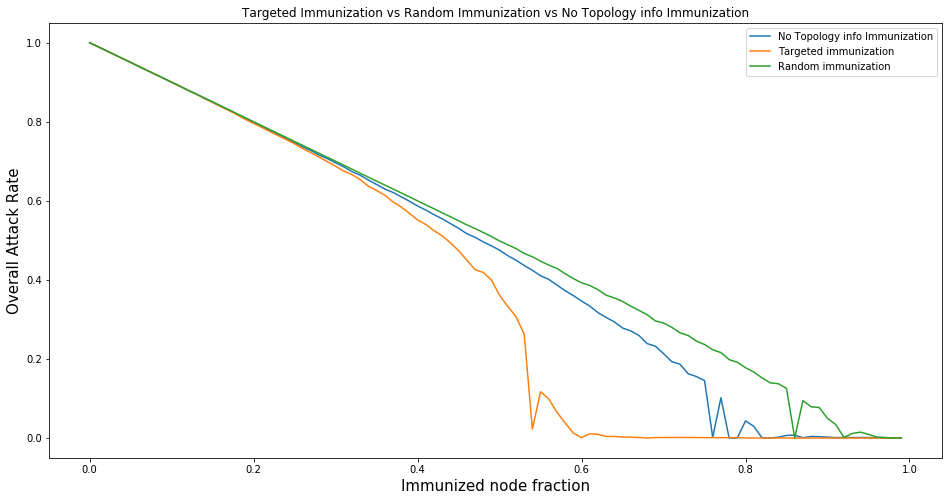

In [107]:
def attack_rate_over_r_times(r_arr, G, nodes_to_remove):
    attack_rate_arr = []
    for r in r_arr:
        G_immun = copy.deepcopy(G)
        # Remove from the Graph M/N nodes with highest degrees
        M = int(np.round(r*len(G.nodes())))
        G_immun.remove_nodes_from(nodes_to_remove[:M])
        # Run the simulation on the modified graph
        SIR_immun = SIRSimulator(G_immun, BETA, MU)
        # Append the simulation value for the curent simulation
        attack_rate_arr.append(attack_rate(SIR_immun.run(num_steps=1), len(G.nodes())))
    return attack_rate_arr

# compute the set of the nodes to be removed for the immunization
nodes_to_remove_times = get_average_earlier_infected_nodes(100, G)

# Setup the simulation
attack_rate_arr_times = attack_rate_over_r_times(r_arr, G, nodes_to_remove_times)

_=plt.figure(figsize=(16,8))
_=plt.title("Targeted Immunization vs Random Immunization vs No Topology info Immunization")
_=plt.xlabel('Immunized node fraction', fontsize=fontsize)
_=plt.ylabel('Overall Attack Rate', fontsize=fontsize)
_=plt.plot(r_arr, attack_rate_arr_times, label = "No Topology info Immunization")
_=plt.plot(r_arr, attack_rate_arr_targeted, label = "Targeted immunization")
_=plt.plot(r_arr, attack_rate_arr_ba, label = "Random immunization")
_=plt.legend()

The results confirm what we expected from the simulation, the lack of information about graph's topology is a price to pay in terms of performance. The average visiting time try to estimate what we have exactly computed before, hence it cannot be a better approach. Anyway, since we have a limited amount of information and the strategy it's acting much better than the Random immunization it can be considered an effective option.

### 	3.3 - Finally, imagine that you have limited information about the social network: you are given a set of K nodes (K << N, say K ~ 10% of the network) and for those K nodes you are given a list of their neighbors. Design a targeted immunization strategy that makes use of this information, and test its performance in simulation. 

Once againg we're interested in a strategy that with a limited amount of information is able to find the more convenient nodes to vaccinate. This time knowing only a subset of $K$ nodes and their neighbors.
A possible approach to solve this problem is to intersect all the list of neighbors of the knowing nodes in order to find friends with higher frequencies and give them the doses. In other words, if you're friend of a lot of people you're an important person for sure!

In [110]:
def get_important_friends(G, k_nodes):
    friends_dict = dict()
    #get friends of the k nodes
    for node in k_nodes:
        # insert in the dict k nodes + friends of k nodes with relative frequencies
        if node not in friends_dict.keys():
            friends_dict[node] = 1
        else:
            friends_dict[node] += 1
        for neighbor in G.neighbors(node):
            if neighbor not in friends_dict.keys():
                friends_dict[neighbor] = 1
            else:
                friends_dict[neighbor] += 1
    # sort the nodes in descending order of frequencies and return as a list
    sorted_friends_dict = sorted(friends_dict.items(), key=itemgetter(1), reverse=True)
    important_friends = [tuple[0] for tuple in sorted_friends_dict]
    return important_friends

def attack_rate_over_r_k(r_arr, G):
    attack_rate_arr = []
    for r in r_arr:
        G_immun = copy.deepcopy(G)
        # pick a fraction r of the network
        n_to_pick = int(np.round(r*len(G.nodes())))
        k_nodes = rnd.sample(G.nodes(), to_pick)
        G_immun.remove_nodes_from(get_important_friends(G_immun, k_nodes)[:n_to_pick])
        # Run the simulation on the modified graph
        SIR_immun = SIRSimulator(G_immun, BETA, MU)
        # Append the simulation value for the curent simulation
        attack_rate_arr.append(attack_rate(SIR_immun.run(num_steps=1), len(G.nodes())))
    return attack_rate_arr


# compute array of attack rate for friend strategy
attack_rate_arr_k = attack_rate_over_r_k(r_arr, G)

Let's plot everything!

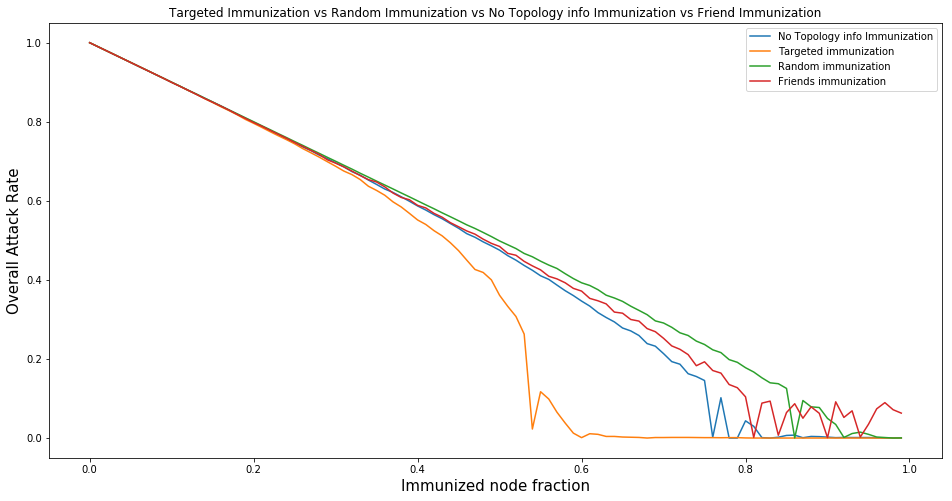

In [111]:
_=plt.figure(figsize=(16,8))
_=plt.title("Targeted Immunization vs Random Immunization vs No Topology info Immunization vs Friend Immunization")
_=plt.xlabel('Immunized node fraction', fontsize=fontsize)
_=plt.ylabel('Overall Attack Rate', fontsize=fontsize)
_=plt.plot(r_arr, attack_rate_arr_times, label = "No Topology info Immunization")
_=plt.plot(r_arr, attack_rate_arr_targeted, label = "Targeted immunization")
_=plt.plot(r_arr, attack_rate_arr_ba, label = "Random immunization")
_=plt.plot(r_arr, attack_rate_arr_k, label = "Friends immunization")
_=plt.legend()

The simulation show us that the strategy of removing most famous friends is kind of bad, is better than the random Immunization strategy but worse of any other strategy we've tested on this notebook. Of course it's performance depens strongly on the $k$ selected, with few information I think that it's behaviour is not really really bad, but if $k$ is approaching a considerable number of nodes maybe would be better to choose the friends withe the higher degrees, in order to simulate as much as possibile a Targeted Immunization.